# Data Preparation

## Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import scipy as sp 

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# Importar funciones necesarias
from pyspark.sql.functions import col, to_date, weekofyear,year, month, dayofmonth, sum
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql.functions import regexp_replace, col, when
from pyspark.sql.functions import format_number
from pyspark.sql.types import IntegerType,FloatType
# Puedes obtener estadísticas específicas para una columna
from pyspark.sql.functions import mean, min, max
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.window import Window
from pyspark.sql.functions import log1p
from pyspark.sql import functions as F

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Import Data

This dataset contains the full LendingClub data available from [their site](https://www.lendingclub.com). There are separate files for accepted and rejected loans. The accepted loans also include the FICO scores, which can only be downloaded when you are signed in to LendingClub and download the data (https://www.kaggle.com/datasets/wordsforthewise/lending-club).



In [2]:

# Crear la sesión de Spark
spark = SparkSession.builder.appName("AppLending").getOrCreate()

# Rutas de los archivos CSV comprimidos
accepted_r = 'hdfs://namenode:8020/datasets/raw/accepted_2007_to_2018Q4.csv.gz'
rejected_r = 'hdfs://namenode:8020/datasets/raw/rejected_2007_to_2018Q4.csv.gz'
#accepted_df = spark.read.csv("hdfs://namenode:8020/datasets/raw/accepted_2007_to_2018Q4.csv.gz", header=True, inferSchema=True)

# Leer los archivos CSV comprimidos usando PySpark
accepted_df = spark.read.option("header", "true").option("inferSchema", "true").csv(accepted_r)
rejected_df = spark.read.option("header", "true").option("inferSchema", "true").csv(rejected_r)

In [3]:
# Haciendo una copia del DataFrame usando alias
accepted_dfm = accepted_df.alias("accepted_dfm")
rejected_dfm = rejected_df.alias("rejected_dfm")

## Explore Data

In [4]:
print((rejected_dfm.count(), len(rejected_dfm.columns)))

(27648741, 9)


In [5]:
print((accepted_dfm.count(), len(accepted_dfm.columns)))

(2260701, 151)


In [4]:
rejected_dfm.printSchema()

root
 |-- Amount Requested: double (nullable = true)
 |-- Application Date: date (nullable = true)
 |-- Loan Title: string (nullable = true)
 |-- Risk_Score: string (nullable = true)
 |-- Debt-To-Income Ratio: string (nullable = true)
 |-- Zip Code: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Employment Length: string (nullable = true)
 |-- Policy Code: string (nullable = true)



In [7]:
rejected_dfm.show()

+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-----------+
|Amount Requested|Application Date|          Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|Policy Code|
+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-----------+
|          1000.0|      2007-05-26|Wedding Covered b...|     693.0|                 10%|   481xx|   NM|          4 years|        0.0|
|          1000.0|      2007-05-26|  Consolidating Debt|     703.0|                 10%|   010xx|   MA|         < 1 year|        0.0|
|         11000.0|      2007-05-27|Want to consolida...|     715.0|                 10%|   212xx|   MD|           1 year|        0.0|
|          6000.0|      2007-05-27|             waksman|     698.0|              38.64%|   017xx|   MA|         < 1 year|        0.0|
|          1500.0|      2007-05-27|              mdrigo|     5

In [4]:
# Aplicar tratamiento para cada columna

rejected_dfm = rejected_dfm.withColumn("Risk_Score", col("Risk_Score").cast("float"))
rejected_dfm = rejected_dfm.withColumn("Debt-To-Income Ratio", regexp_replace(col("Debt-To-Income Ratio"), "%", "").cast("float") / 100.0)
rejected_dfm = rejected_dfm.withColumn("Zip Code", regexp_replace(col("Zip Code"), "[^0-9]", ""))
rejected_dfm = rejected_dfm.withColumn("Policy Code", col("Policy Code").cast("int"))

In [9]:
# Verificar valores nulos por columna y contarlos
null_counts = rejected_dfm.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in rejected_dfm.columns])
null_counts.show()

+----------------+----------------+----------+----------+--------------------+--------+-----+-----------------+-----------+
|Amount Requested|Application Date|Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|Policy Code|
+----------------+----------------+----------+----------+--------------------+--------+-----+-----------------+-----------+
|               0|               0|      1303|         0|                   0|     293|   22|           951355|          0|
+----------------+----------------+----------+----------+--------------------+--------+-----+-----------------+-----------+



| Campo                | Descripción                                                                                                     |
|----------------------|-----------------------------------------------------------------------------------------------------------------|
| Amount Requested     | La cantidad total solicitada por el prestatario.                                                                  |
| Application Date     | La fecha en la cual el prestatario presentó la solicitud.                                                         |
| Loan Title           | El título del préstamo proporcionado por el prestatario.                                                            |
| Risk_Score           | Para aplicaciones anteriores al 5 de noviembre de 2007, la puntuación de riesgo es la puntuación FICO del prestatario. Para aplicaciones después del 5 de noviembre de 2018, la puntuación de riesgo es la puntuación Vantage del prestatario. |
| Debt-To-Income Ratio | Una proporción calculada utilizando los pagos mensuales totales del prestatario en las obligaciones de deuda totales, excluyendo la hipoteca y el préstamo solicitado a través de LC, dividido por los ingresos mensuales autodeclarados del prestatario. |
| Zip Code             | Los primeros 3 números del código postal proporcionado por el prestatario en la solicitud de préstamo.           |
| State                | El estado proporcionado por el prestatario en la solicitud de préstamo.                                            |
| Employment Length    | Duración del empleo en años. Los valores posibles están entre 0 y 10, donde 0 significa menos de un año y 10 significa diez o más años. |
| Policy Code          | Código de política disponible públicamente. policy_code=1 para nuevos productos no disponibles públicamente, policy_code=2. |


In [12]:
# Revisemos el Target del los Créditos Rechazados
rejected_dfm_keys = rejected_dfm.select("Risk_Score").distinct()
rejected_dfm_keys.show()

+----------+
|Risk_Score|
+----------+
|     714.0|
|     550.0|
|     769.0|
|     364.0|
|     886.0|
|     729.0|
|     803.0|
|     362.0|
|     425.0|
|     955.0|
|     332.0|
|     692.0|
|     797.0|
|     911.0|
|     615.0|
|     829.0|
|     331.0|
|     308.0|
|     500.0|
|     547.0|
+----------+
only showing top 20 rows



In [8]:
# Obtener solo las columnas numéricas
rejected_dfm_numeric= [col_name for col_name, col_type in rejected_dfm.dtypes if col_type in ['int', 'bigint', 'double', 'float']]
# Estadísticas descriptivas de las columnas numéricas

# Calcular estadísticas descriptivas solo para las columnas numéricas
# rejected_dfm.select(rejected_dfm_numeric).describe().show()

# Calcular estadísticas descriptivas solo para las columnas numéricas
descriptive_stats= rejected_dfm.select(rejected_dfm_numeric).describe()

# Aplicar formato a las columnas numéricas para mostrar solo dos decimales
rejected_dfm_stats = descriptive_stats.select(
    descriptive_stats["summary"],
    *[format_number(descriptive_stats[col].cast("double"), 2).alias(col) for col in descriptive_stats.columns[1:]]
)

# Mostrar la tabla de estadísticas descriptivas formateada
rejected_dfm_stats.show()

+-------+----------------+------------+--------------------+-------------+
|summary|Amount Requested|  Risk_Score|Debt-To-Income Ratio|  Policy Code|
+-------+----------------+------------+--------------------+-------------+
|  count|   27,648,741.00|9,151,110.00|       27,648,740.00|27,647,822.00|
|   mean|       13,133.24|      628.17|                1.43|         0.01|
| stddev|       15,009.64|       89.94|              105.39|         0.11|
|    min|            0.00|        0.00|               -0.01|         0.00|
|    max|    1,400,000.00|      990.00|          500,000.32|         2.00|
+-------+----------------+------------+--------------------+-------------+



***Interpretación***:<br>
La ***cantidad total solicitada*** por los prestatarios varía desde 0 hasta 1,400,000, con una media de aproximadamente 13,133.24.
Risk Score (Puntuación de Riesgo):

Las ***puntuaciones de riesgo*** van desde 0 hasta 990. La media es aproximadamente 628.17.
Debt-To-Income Ratio (Relación Deuda-Ingresos):

La ***relación deuda-ingresos*** varía significativamente, con una media de alrededor de 35,218.37. Sin embargo, hay una gran desviación estándar, indicando una variabilidad significativa.
Policy Code (Código de Política):

El ***código de política*** tiene dos valores posibles: 1 y 2, y parece tener una media de alrededor de 0.64, con una desviación estándar de 11.27.

#### Hipostesis planteada
***Relación entre Amount Requested y Debt-To-Income Ratio:***

Hipótesis: Existe una correlación significativa entre la cantidad solicitada y la relación deuda-ingresos. Los prestatarios que solicitan grandes cantidades podrían tener relaciones deuda-ingresos más altas.

In [21]:
rejected_dfm.show()

+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-----------+
|Amount Requested|Application Date|          Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|Policy Code|
+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-----------+
|          1000.0|      2007-05-26|Wedding Covered b...|     693.0|                 0.1|     481|   NM|          4 years|          0|
|          1000.0|      2007-05-26|  Consolidating Debt|     703.0|                 0.1|     010|   MA|         < 1 year|          0|
|         11000.0|      2007-05-27|Want to consolida...|     715.0|                 0.1|     212|   MD|           1 year|          0|
|          6000.0|      2007-05-27|             waksman|     698.0|  0.3863999938964844|     017|   MA|         < 1 year|          0|
|          1500.0|      2007-05-27|              mdrigo|     5

In [5]:
# Análisis descriptivo
rejected_dfm.describe(["Amount Requested", "Debt-To-Income Ratio"]).show()

+-------+------------------+--------------------+
|summary|  Amount Requested|Debt-To-Income Ratio|
+-------+------------------+--------------------+
|  count|          27648741|            27648740|
|   mean|13133.240308610437|   1.433400558424447|
| stddev|15009.636324282348|   105.3916344829097|
|    min|               0.0|               -0.01|
|    max|         1400000.0|           500000.32|
+-------+------------------+--------------------+



In [30]:
print(type(sampled_pd_data))

<class 'pandas.core.frame.DataFrame'>


In [31]:
print(type(sampled_data))

<class 'pyspark.sql.dataframe.DataFrame'>


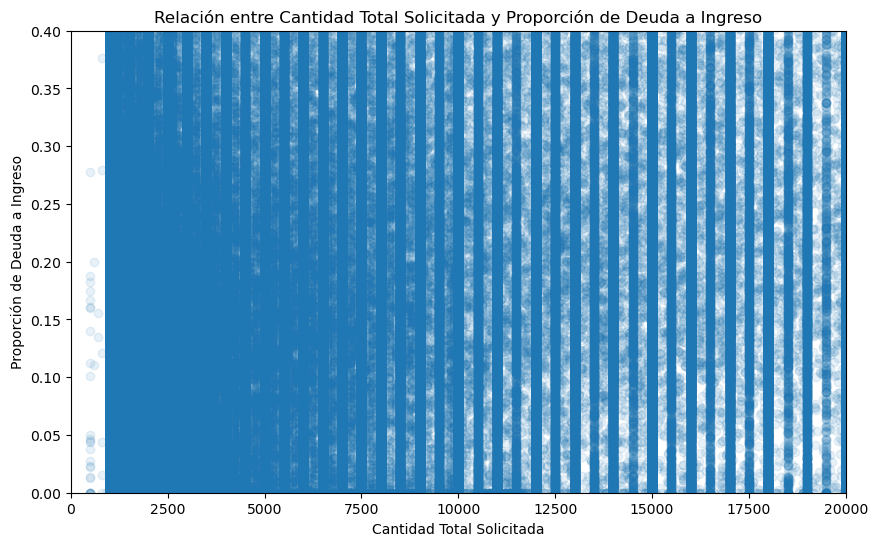

In [5]:
%matplotlib inline
# Análisis exploratorio de datos (EDA)
sampled_data = rejected_dfm.select(["Amount Requested", "Debt-To-Income Ratio"]).sample(fraction=0.1, seed=42)
sampled_pd_data = sampled_data.toPandas()

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Establecer límites de los ejes
plt.xlim(0, 20000) 
plt.ylim(0, 0.4)    

plt.scatter(
    sampled_pd_data["Amount Requested"],
    sampled_pd_data["Debt-To-Income Ratio"],
    alpha=0.1
)

plt.title("Relación entre Cantidad Total Solicitada y Proporción de Deuda a Ingreso")
plt.xlabel("Cantidad Total Solicitada")
plt.ylabel("Proporción de Deuda a Ingreso")
plt.show()

***Amount Requested (Cantidad Total Solicitada):*** La mayoría de las solicitudes se concentran en la región de montos más bajos, especialmente por debajo de 10,000. Esto indica que la mayoría de los prestatarios tienden a solicitar cantidades relativamente pequeñas.

***Debt-To-Income Ratio (Proporción de Deuda a Ingreso):*** La mayoría de los prestatarios exhiben una proporción de deuda a ingreso por debajo del 0.4. Esto sugiere que la mayoría de los prestatarios tienden a tener una carga de deuda razonable en comparación con sus ingresos mensuales autodeclarados.

***Histograma de distribución uniforme*** puede sugerir que no hay sesgo evidente hacia ciertos montos o proporciones de deuda a ingreso, lo que podría ser una buena señal en términos de diversidad y equilibrio en las solicitudes de préstamos.En decir,las decisiones de rechazo no están fuertemente influenciadas por rangos específicos de estas variables. Sin embargo, para una evaluación más completa, se podrían considerar otras variables y técnicas de análisis.

In [11]:
# Correlación
correlation = rejected_dfm.stat.corr("Amount Requested", "Debt-To-Income Ratio")
print(f"Correlación entre Amount Requested y Debt-To-Income Ratio: {correlation}")

Correlación entre Amount Requested y Debt-To-Income Ratio: 0.0005456627721081024


***La correlación*** cercana a cero indica que no hay una relación lineal fuerte entre estas dos variables, los montos solicitados no están fuertemente asociados con la proporción deuda-ingreso en el conjunto de datos de créditos rechazados.

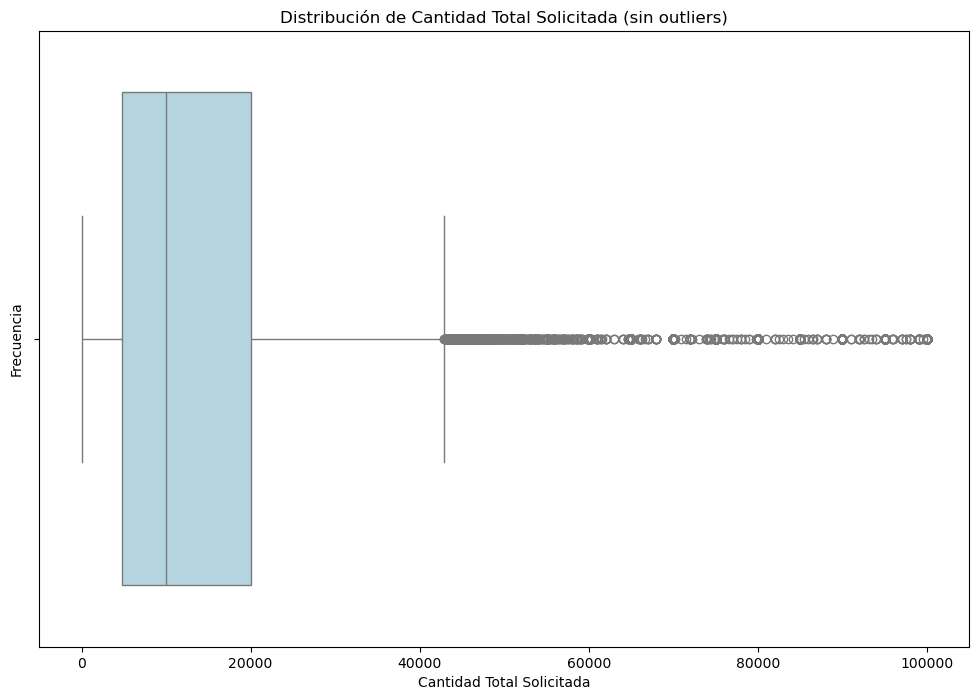

In [6]:
%matplotlib inline
# Ajustar los límites
amount_requested_threshold = 100000

# Filtrar outliers
filtered_data = sampled_pd_data[sampled_pd_data["Amount Requested"] <= amount_requested_threshold]

# Crear la gráfica 
plt.figure(figsize=(12, 8))

# Añadir color para destacar outliers
sns.boxplot(x=filtered_data["Amount Requested"], color='lightblue')  # Puedes ajustar el color según tus preferencias


plt.title("Distribución de Cantidad Total Solicitada (sin outliers)")
plt.xlabel("Cantidad Total Solicitada")
plt.ylabel("Frecuencia")

# Mostrar la gráfica
plt.show()

In [9]:
# Crear un ensamblador de vectores con las columnas numéricas y manejar nulos
assembler = VectorAssembler(inputCols=rejected_dfm_numeric, outputCol="features", handleInvalid="keep")

# Aplicar el ensamblaje a los datos
assembled_data = assembler.transform(rejected_dfm.na.drop(subset=rejected_dfm_numeric))

# Calcular la matriz de correlación
correlation_matrix = Correlation.corr(assembled_data, "features").collect()[0][0]

# Convertir la matriz de correlación a un DataFrame de Spark para mostrar
correlation_df = spark.createDataFrame(correlation_matrix.toArray().tolist(), rejected_dfm_numeric)

# Renombrar las columnas del DataFrame de correlación
correlation_df = correlation_df.toDF(*rejected_dfm_numeric)

# Mostrar la matriz de correlación
print("Matriz de Correlación:")
correlation_df.show(truncate=False)

Matriz de Correlación:
+---------------------+----------------------+----------------------+----------------------+
|Amount Requested     |Risk_Score            |Debt-To-Income Ratio  |Policy Code           |
+---------------------+----------------------+----------------------+----------------------+
|1.0                  |0.24322848684674706   |0.0012091458202760786 |0.008266359131102822  |
|0.24322848684674706  |1.0                   |-0.0018622747403341093|0.03872342087102035   |
|0.0012091458202760786|-0.0018622747403341093|1.0                   |-2.9259927128903697E-4|
|0.008266359131102822 |0.03872342087102035   |-2.9259927128903697E-4|1.0                   |
+---------------------+----------------------+----------------------+----------------------+



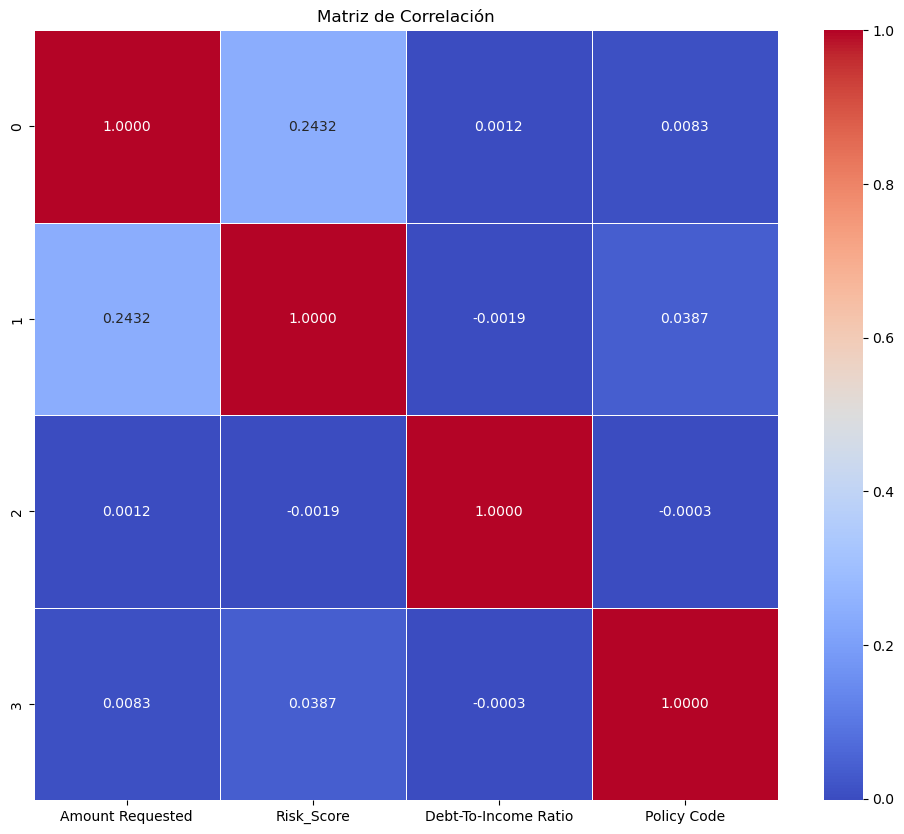

In [10]:
%matplotlib inline
# Convertir la matriz de correlación a un DataFrame de pandas
correlation_pd_df = correlation_df.toPandas()

# Crear una heatmap usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_pd_df, annot=True, cmap="coolwarm", fmt=".4f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()


- Los resultados muestran que ***la correlación*** entre la "Cantidad Solicitada" y la "Proporción de Deuda a Ingreso" es extremadamente baja, con un valor de aproximadamente 0.0012. Además, la correlación entre la "Cantidad Solicitada" y el "Código de Póliza" es positiva pero muy débil, alrededor de 0.0083. Estos valores confirman que, desde una perspectiva lineal, la "Cantidad Solicitada" no está fuertemente vinculada a ninguno de estos dos atributos.
- Es fundamental tener en cuenta que la correlación no implica causalidad, y estos resultados sugieren que otros factores o relaciones no lineales pueden influir en la interacción entre estas variables. Por lo tanto, se enfatiza la necesidad de emplear métodos adicionales de análisis y modelado.